In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.utils import shuffle

In [2]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [3]:
test_size = 100
x_train, y_train = np.load("x_train50x50.npz")['arr_0'], np.load("y_train50x50.npz")['arr_0']
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = x_train[-test_size:], y_train[-test_size:]
x_train, y_train = x_train[:-test_size], y_train[:-test_size]
x_train = x_train
x_test = x_test
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1000, 50, 50, 3), (1000, 11), (100, 50, 50, 3), (100, 11))

In [4]:
classifications = ['cpp_go_left', 'cpp_go_right', 'cpp_notgo', 'cpp_onlygo', 'cpp_onlyleft', 'cpp_onlyright', 'cpp_stop_line', 'cpp_stop_pic', 'notleft_sign', 'notright_pic', 'notstop_pic']
len(classifications)

11

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


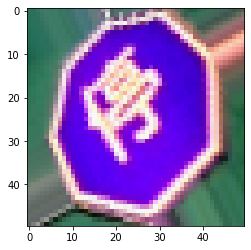

cpp_stop_pic


In [5]:
datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True,
    channel_shift_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
)

data = datagen.flow(x_train, y_train, batch_size=32)

n = 16
plt.imshow(data[n][0][0])
plt.show()
print(classifications[np.where(data[n][1][0]==1)[0][0]])

In [6]:
model = None
model = Sequential([
    layers.Input(shape=(50, 50, 3)),
    # layers.BatchNormalization(),
    
    layers.Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(500, activation='sigmoid'),
    layers.Dense(200, activation='sigmoid'),
    layers.Dense(len(classifications), activation='softmax'),
])

model.summary()


2022-08-15 09:49:21.086807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 09:49:21.087691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                              

Epoch 1/15


/var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/ipykernel_98638/128467735.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(data,  epochs=15, verbose=1,
2022-08-15 09:49:21.470974: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-15 09:49:21.832855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 35ms/step - loss: 0.3357 - accuracy: 0.1040 - val_loss: 0.2865 - val_accuracy: 0.2500
Epoch 2/15
 1/32 [..............................] - ETA: 1s - loss: 0.2849 - accuracy: 0.2500

2022-08-15 09:49:23.186301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 28ms/step - loss: 0.2670 - accuracy: 0.3030 - val_loss: 0.2527 - val_accuracy: 0.3200
Epoch 3/15
32/32 [==============================] - 1s 24ms/step - loss: 0.2333 - accuracy: 0.4870 - val_loss: 0.2158 - val_accuracy: 0.5000
Epoch 4/15
32/32 [==============================] - 1s 27ms/step - loss: 0.1974 - accuracy: 0.6640 - val_loss: 0.1799 - val_accuracy: 0.8400
Epoch 5/15
32/32 [==============================] - 1s 22ms/step - loss: 0.1589 - accuracy: 0.7700 - val_loss: 0.1459 - val_accuracy: 0.8400
Epoch 6/15
32/32 [==============================] - 1s 22ms/step - loss: 0.1276 - accuracy: 0.8200 - val_loss: 0.1192 - val_accuracy: 0.7900
Epoch 7/15
32/32 [==============================] - 1s 23ms/step - loss: 0.1016 - accuracy: 0.8850 - val_loss: 0.0916 - val_accuracy: 0.9100
Epoch 8/15
32/32 [==============================] - 1s 21ms/step - loss: 0.0835 - accuracy: 0.9180 - val_loss: 0.0749 - val_accuracy: 0.9400
Epoch 9/15
32/32 [======

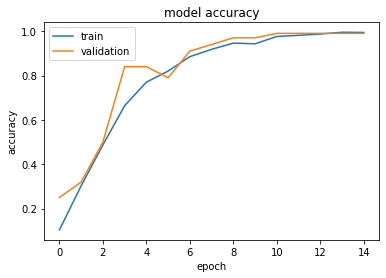

Test:
Loss: 0.024125486612319946
Accuracy: 0.9899999499320984


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
hist = model.fit_generator(data,  epochs=15, verbose=1,
                           validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
plot_hist(hist)
print('Test:')
print('Loss: %s\nAccuracy: %s' % (loss, accuracy))


In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmph2xs8wy8/assets


INFO:tensorflow:Assets written to: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmph2xs8wy8/assets
2022-08-15 09:49:36.160227: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-15 09:49:36.160247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-15 09:49:36.160973: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmph2xs8wy8
2022-08-15 09:49:36.162179: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-15 09:49:36.162189: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmph2xs8wy8
2022-08-15 09:49:36.166332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-15 09:49:36.167976: I tensorflow/cc/saved_model/load